In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


ImportError: cannot import name 'get_nwloocv_predictions_multimodel_merge_dists' from 'mcmodels.models.crossvalidation' (/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py)

In [ ]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [5]:
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

In [7]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [14]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [12]:
#reg_proj is the regionalized summary structure predictions
#connectivity_data.structure_datas[315].reg_proj_norm

#reg_proj_norm is the normalized by total proj

#reg_proj_vcount_norm divides by target size (leaf or summary)

#reg_proj_vcount_norm_renorm divides reg_proj_vcount_norm by total norm

#reg_ipsi_inj is the regionalized leaf or summary injections

#
#reg_inj_vcount_norm divides by size (target or summary)

#reg_proj_vcount_norm_injnorm is reg_proj_vcount_norm divided by reg_inj_vcount_norm
#which seems like maybe not the best idea....

In [ ]:
#12 by 6 boxplots

0
1
2
3
4
5
6
7
8
9
10
11


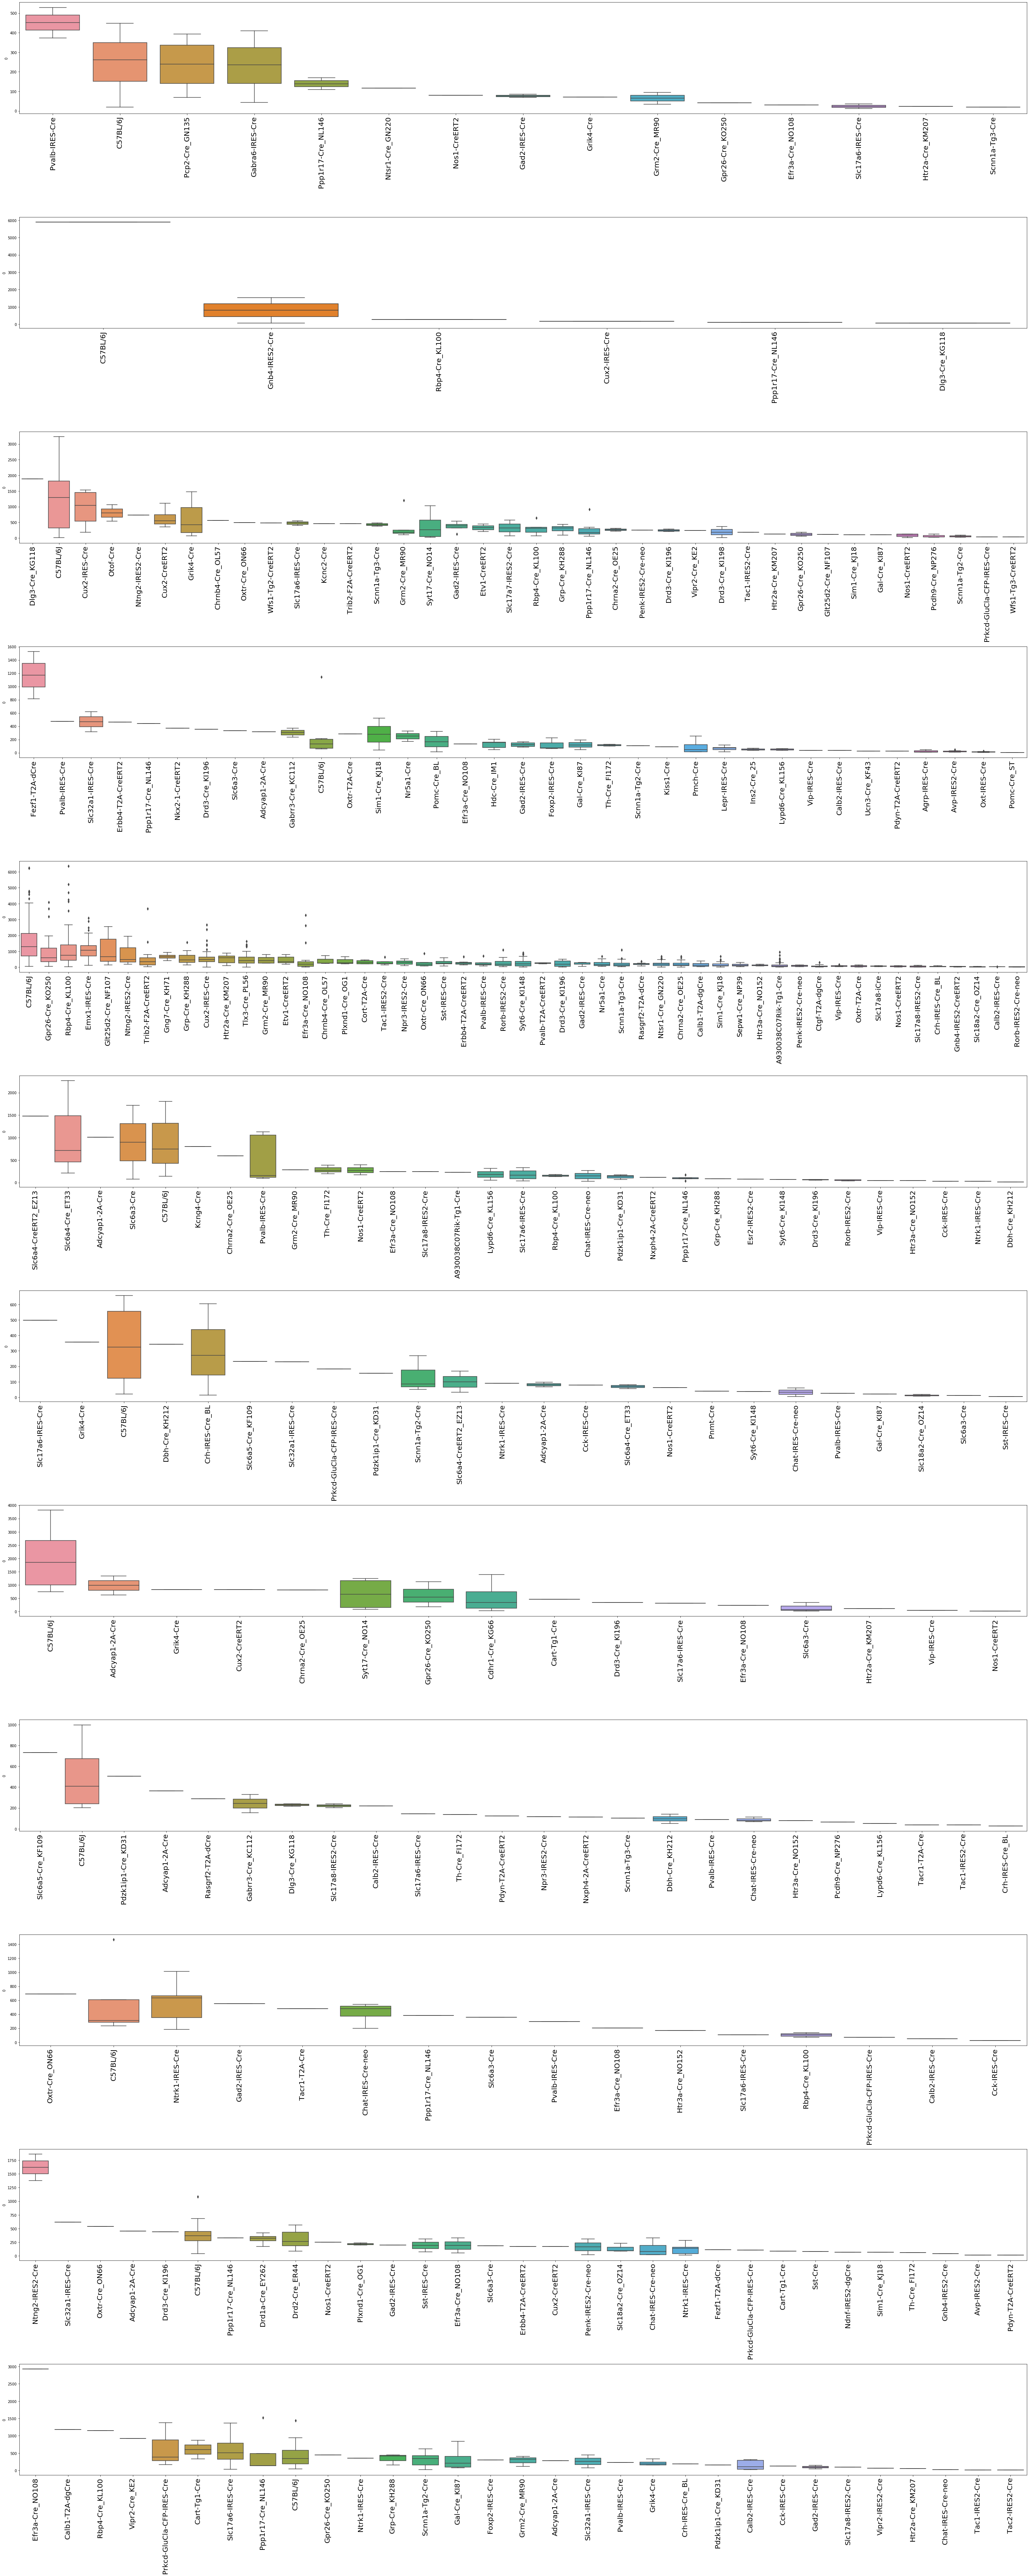

In [52]:
%matplotlib inline
nms = len(major_structure_ids)
fig, axes = plt.subplots(nms,1, figsize = (40,100))
#for m in range(1):
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    
    proj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj, axis = 1)
    inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
    proj_injnorm_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj_injnorm, axis = 1)
    #inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
        
    projnorm_bycre = pd.DataFrame([proj_norm, connectivity_data.creline[sid]]).transpose()
#     projnorm_byleaf = pd.DataFrame(np.asarray([proj_norm, leafs[sid]]).transpose())
#     injnorm_bycre = pd.DataFrame(np.asarray([inj_norm, connectivity_data.creline[sid]]).transpose())
#     injnorm_byleaf = pd.DataFrame(np.asarray([inj_norm, leafs[sid]]).transpose())
#     proj_injnorm_bycre = pd.DataFrame(np.asarray([proj_injnorm_norm, connectivity_data.creline[sid]]).transpose())
#     proj_injnorm_byleaf = pd.DataFrame(np.asarray([proj_injnorm_norm, leafs[sid]]).transpose())    
        
#     losses_bycre = projnorm_bycre.astype({0: np.float64})
    projnorm_bycre = projnorm_bycre.astype({0: np.float64})
    order = np.unique(projnorm_bycre[1])[(-projnorm_bycre.groupby(by=[1])[0].mean()).argsort()]
    sns.boxplot(x =  connectivity_data.creline[sid], y = projnorm_bycre.loc[:,0], ax=axes[m], order = order)
    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 20)





    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
#    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
#    axes[m].tick_params(axis='y', which='major', labelsize=30)
#    axes[m].set_ylabel(major_structures[m], fontsize = 60)
    
#    axes[0].set_title('Voxel-loss', fontsize = 60)
plt.tight_layout() 


0
1
2
3
4
5
6
7
8
9
10
11


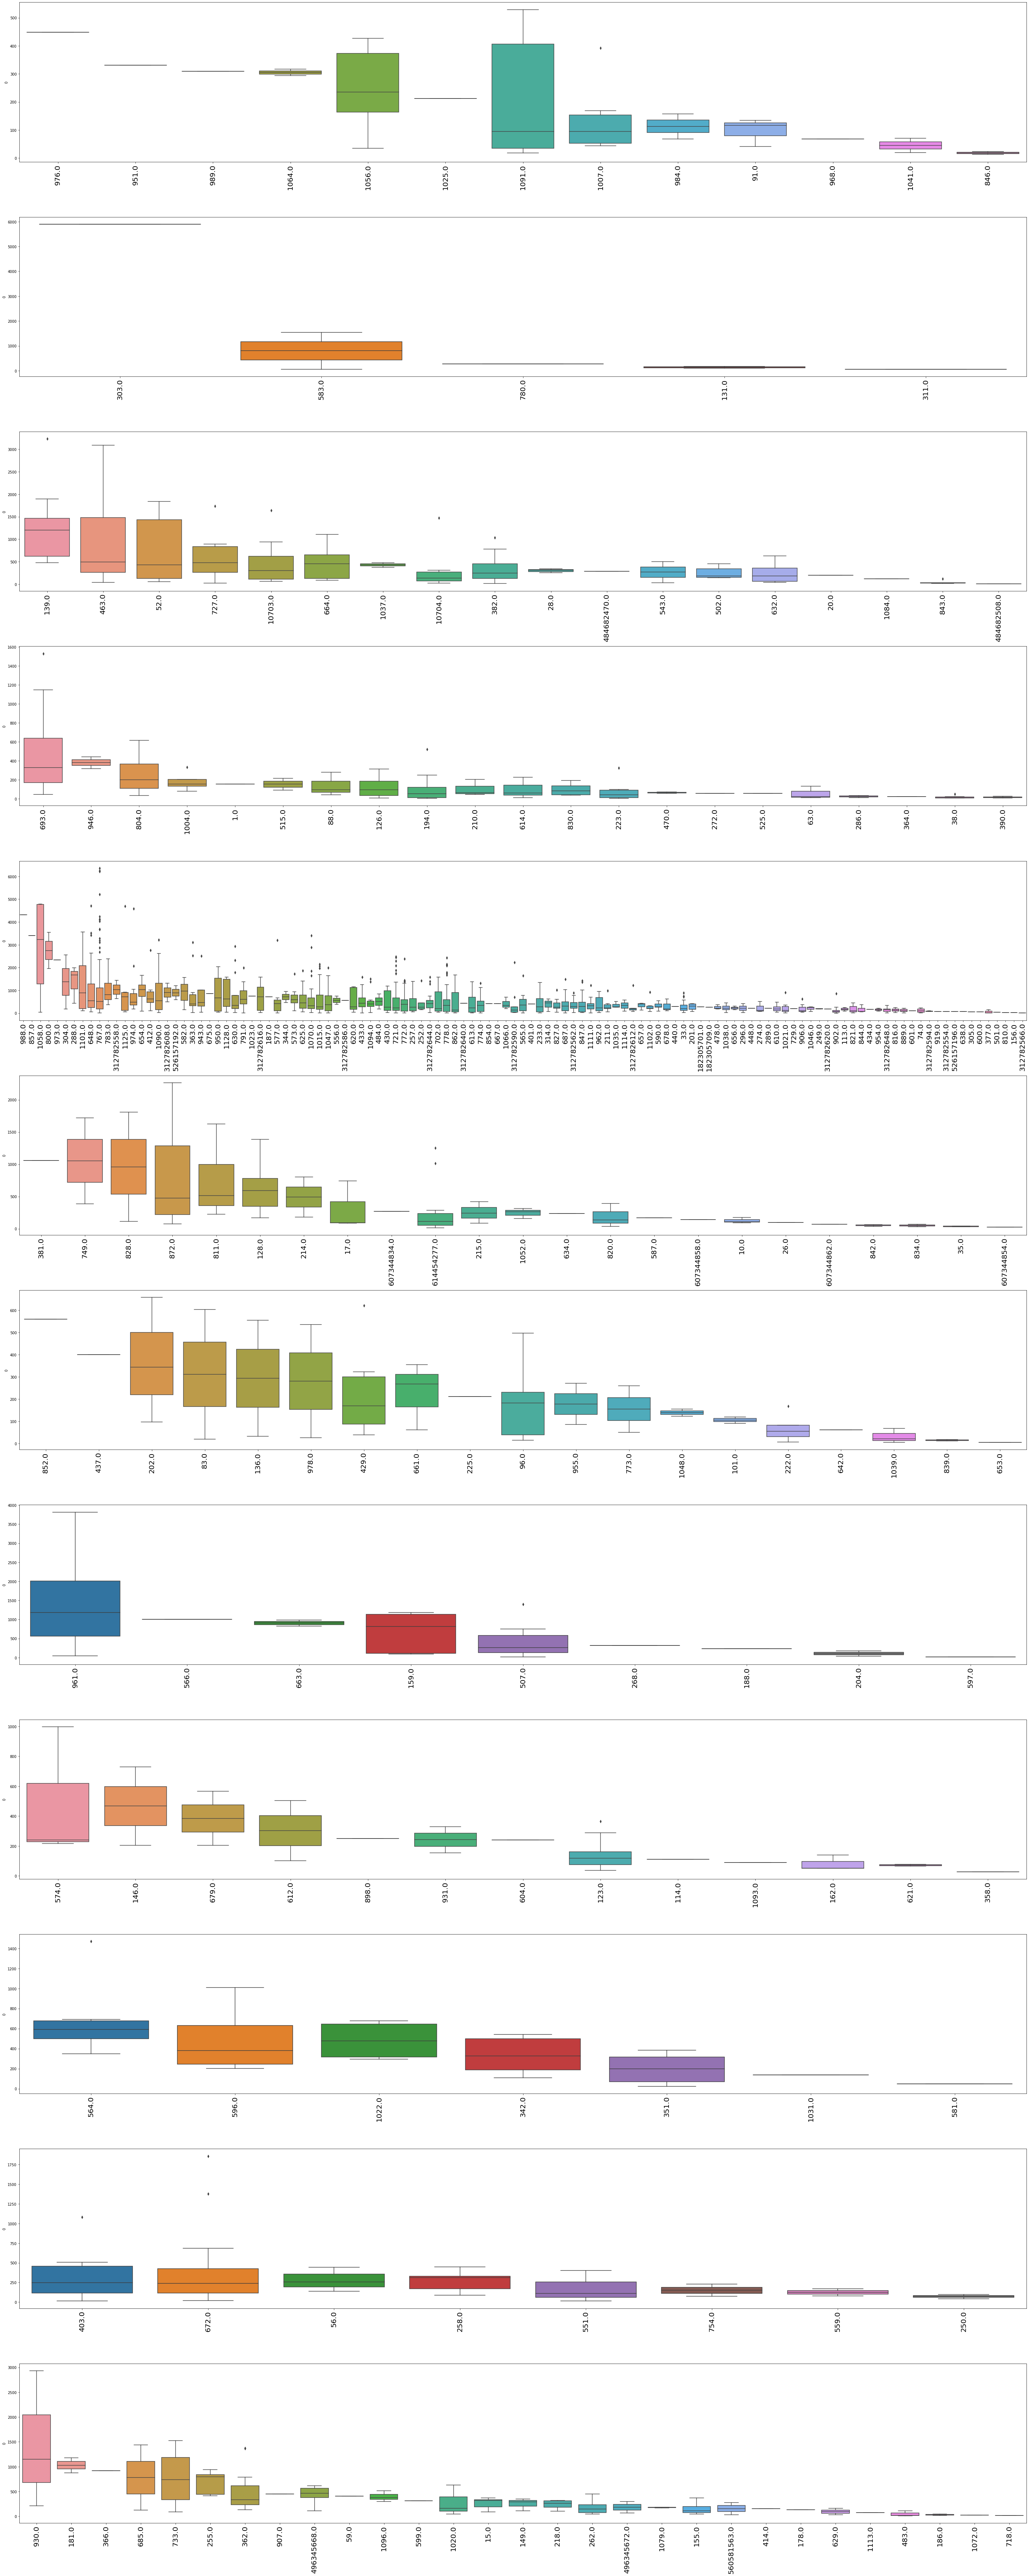

In [55]:
%matplotlib inline
nms = len(major_structure_ids)
fig, axes = plt.subplots(nms,1, figsize = (40,100))
#for m in range(1):
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    
    proj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj, axis = 1)
    inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
    proj_injnorm_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj_injnorm, axis = 1)
    #inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
        
    #    projnorm_bycre = pd.DataFrame([proj_norm, connectivity_data.creline[sid]]).transpose()
    projnorm_byleaf = pd.DataFrame(np.asarray([proj_norm, leafs[sid]]).transpose())
    #     injnorm_bycre = pd.DataFrame(np.asarray([inj_norm, connectivity_data.creline[sid]]).transpose())
#     injnorm_byleaf = pd.DataFrame(np.asarray([inj_norm, leafs[sid]]).transpose())
#     proj_injnorm_bycre = pd.DataFrame(np.asarray([proj_injnorm_norm, connectivity_data.creline[sid]]).transpose())
#     proj_injnorm_byleaf = pd.DataFrame(np.asarray([proj_injnorm_norm, leafs[sid]]).transpose())    
        
#     losses_bycre = projnorm_bycre.astype({0: np.float64})
    projnorm_byleaf = projnorm_byleaf.astype({0: np.float64})
    order = np.unique(projnorm_byleaf[1])[(-projnorm_byleaf.groupby(by=[1])[0].mean()).argsort()]
    sns.boxplot(x =  leafs[sid], y = projnorm_byleaf.loc[:,0], ax=axes[m], order = order)
    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 20)





    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
#    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
#    axes[m].tick_params(axis='y', which='major', labelsize=30)
#    axes[m].set_ylabel(major_structures[m], fontsize = 60)
    
#    axes[0].set_title('Voxel-loss', fontsize = 60)
plt.tight_layout() 


0
1
2
3
4
5
6
7
8
9
10
11


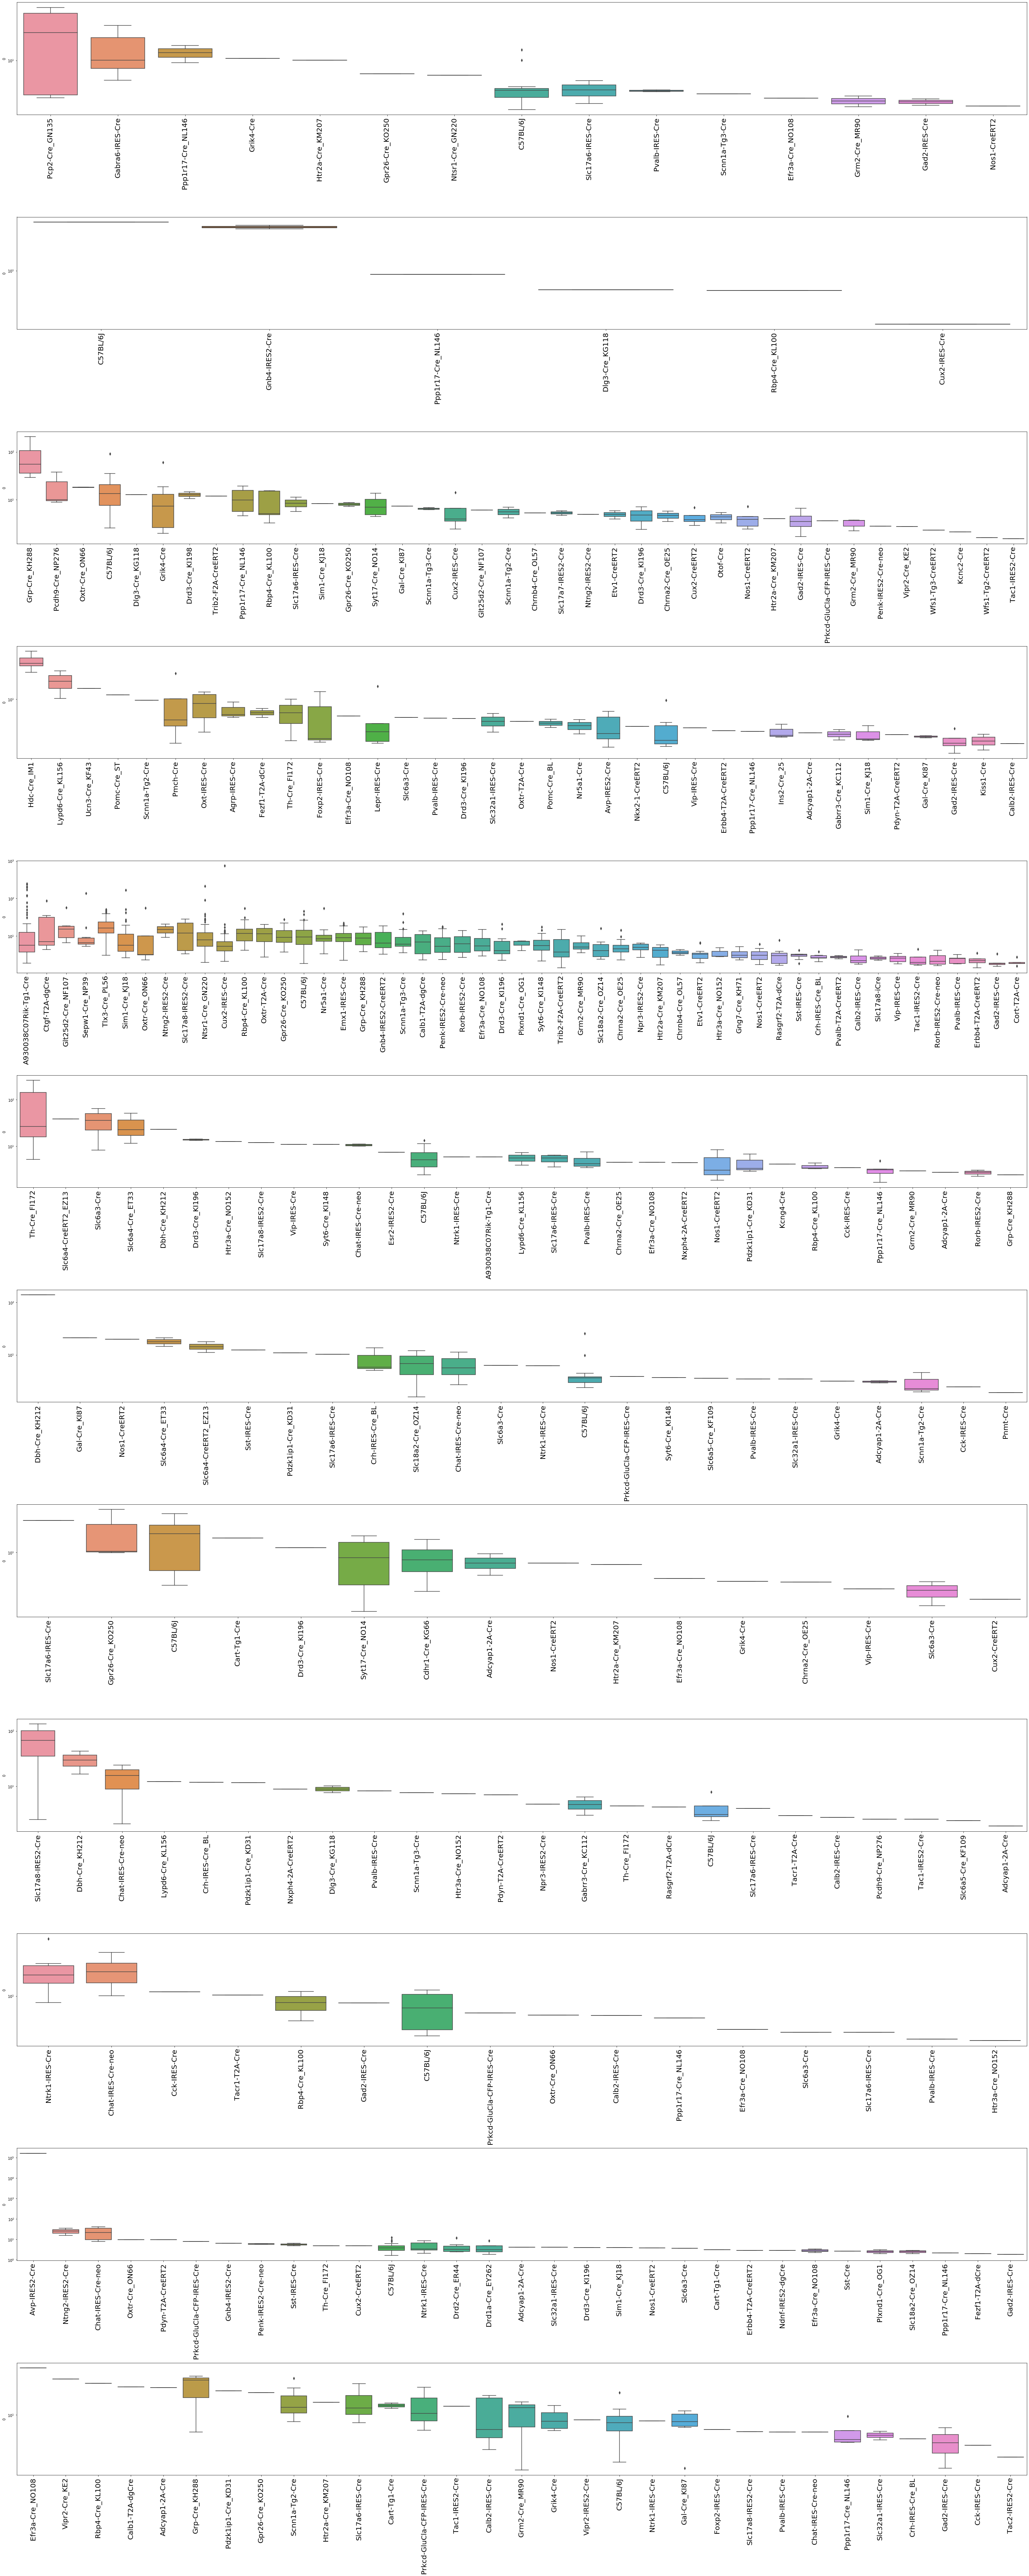

In [58]:
%matplotlib inline
nms = len(major_structure_ids)
fig, axes = plt.subplots(nms,1, figsize = (40,100))
#for m in range(1):
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    
    proj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj, axis = 1)
    inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
    proj_injnorm_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_proj_injnorm, axis = 1)
    #inj_norm = np.linalg.norm(connectivity_data.structure_datas[sid].reg_inj, axis = 1)
        
    #    projnorm_bycre = pd.DataFrame([proj_norm, connectivity_data.creline[sid]]).transpose()
    #projnorm_byleaf = pd.DataFrame(np.asarray([proj_norm, leafs[sid]]).transpose())
    #     injnorm_bycre = pd.DataFrame(np.asarray([inj_norm, connectivity_data.creline[sid]]).transpose())
#     injnorm_byleaf = pd.DataFrame(np.asarray([inj_norm, leafs[sid]]).transpose())
    proj_injnorm_bycre = pd.DataFrame(np.asarray([proj_injnorm_norm, connectivity_data.creline[sid]]).transpose())
#     proj_injnorm_byleaf = pd.DataFrame(np.asarray([proj_injnorm_norm, leafs[sid]]).transpose())    
        
#     losses_bycre = projnorm_bycre.astype({0: np.float64})
    proj_injnorm_bycre = proj_injnorm_bycre.astype({0: np.float64})
    order = np.unique(proj_injnorm_bycre[1])[(-proj_injnorm_bycre.groupby(by=[1])[0].mean()).argsort()]
    sns.boxplot(x =  connectivity_data.creline[sid], y = proj_injnorm_bycre.loc[:,0], ax=axes[m], order = order)
    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 20)

    axes[m].set_yscale('symlog', linthreshy=1e0)



    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
#    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
#    axes[m].tick_params(axis='y', which='major', labelsize=30)
#    axes[m].set_ylabel(major_structures[m], fontsize = 60)
    
#    axes[0].set_title('Voxel-loss', fontsize = 60)
plt.tight_layout() 


In [ ]:
#scatter plot proj_norm, inj_norm with error bars

In [ ]:
help(pdg.mean)